02:00:01 - cmdstanpy - INFO - Chain [1] start processing
02:00:01 - cmdstanpy - INFO - Chain [1] done processing


----- Prophet Model Evaluation (Test Set) -----
R²: -0.6215
RMSE: 20217.53
MAE: 10861.20


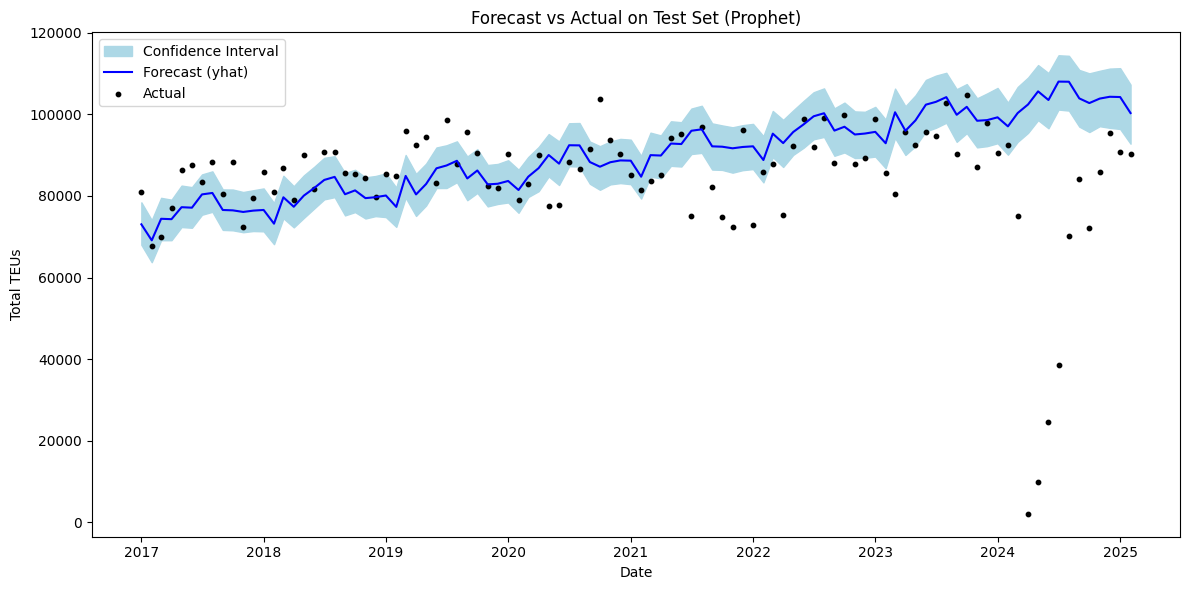

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1. Load and prepare the data
df = pd.read_excel("Baltimore.xls")
df['ds'] = pd.to_datetime(df['Month'], format='%b-%y')
df = df[['ds', 'Total TEUs']].rename(columns={'Total TEUs': 'y'})
df = df.sort_values('ds').reset_index(drop=True)

# 2. Split into training and testing sets (by chronological order)
train_ratio = 0.7
split_index = int(len(df) * train_ratio)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# 3. Fit Prophet model (using training set only)
model = Prophet()
model.fit(train_df)

# 4. Create future dataframe using test set dates
future = pd.DataFrame({'ds': test_df['ds']})
forecast = model.predict(future)

# 5. Merge forecast results with actual test data
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
test_eval = test_df.merge(forecast, on='ds')

# 6. Model evaluation
rmse = np.sqrt(mean_squared_error(test_eval['y'], test_eval['yhat']))
mae = mean_absolute_error(test_eval['y'], test_eval['yhat'])
r2 = r2_score(test_eval['y'], test_eval['yhat'])

# 7. Print evaluation results
print("----- Prophet Model Evaluation (Test Set) -----")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 8. Visualization (test set forecast)
plt.figure(figsize=(12, 6))
plt.fill_between(test_eval['ds'], test_eval['yhat_lower'], test_eval['yhat_upper'], color='lightblue', label='Confidence Interval')
plt.plot(test_eval['ds'], test_eval['yhat'], color='blue', label='Forecast (yhat)')
plt.scatter(test_eval['ds'], test_eval['y'], color='black', s=10, label='Actual')
plt.title("Forecast vs Actual on Test Set (Prophet)")
plt.xlabel("Date")
plt.ylabel("Total TEUs")
plt.legend()
plt.tight_layout()
plt.show()


## run one time ✅

In [8]:
# Prophet Evaluation Template for Time Series Forecasting (Single Training Version)

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from memory_profiler import memory_usage
import time

def build_prophet_model(df, train_ratio=0.7, verbose=False):
    df = df.sort_values('ds').dropna().reset_index(drop=True)
    split_index = int(len(df) * train_ratio)
    train_df = df.iloc[:split_index].copy()
    test_df = df.iloc[split_index:].copy()

    # record time and memory usage
    def train_model():
        model = Prophet()
        model.fit(train_df)
        return model

    start_time = time.time()
    mem_usage, model = memory_usage(train_model, retval=True, max_usage=True)
    end_time = time.time()

    print(f"time usage {end_time - start_time:.2f}s | memory usage {mem_usage:.2f} MB")

    # Predict
    future = pd.DataFrame({'ds': test_df['ds']})
    forecast = model.predict(future)
    predictions = forecast['yhat'].values.tolist()

    return predictions, train_df, test_df



def generate_model_metrics(predictions, test):
    """
    Compute evaluation metrics for model predictions.

    Parameters:
        predictions: predicted values (list or array)
        test: actual values (list or array)

    Returns:
        rmse, mse, mae, mape, r2, adj_r2: evaluation metrics
    """
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    mape = np.mean(np.abs((test - predictions) / test)) * 100 if np.any(test) else 0
    r2 = r2_score(test, predictions)
    n = len(test)
    p = 1
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return rmse, mse, mae, mape, r2, adj_r2


def run_prophet_forecast(filepath, date_col, value_col, train_ratio=0.7, verbose=False):
    """
    Complete pipeline to load data, run Prophet, and evaluate.

    Parameters:
        filepath: path to the CSV file
        date_col: column name for timestamps
        value_col: column name for values to forecast
        train_ratio: train/test split ratio
        verbose: whether to print step-by-step predictions
    """
    df = pd.read_csv(filepath)
    df['ds'] = pd.to_datetime(df[date_col])
    df['y'] = df[value_col]
    df = df[['ds', 'y']]

    predictions, train_df, test_df = build_prophet_model(df, train_ratio, verbose)
    test_y = test_df['y'].values
    rmse, mse, mae, mape, r2, adj_r2 = generate_model_metrics(np.array(predictions), test_y)

    print("\n----- Prophet Model Evaluation (Test Set) -----")
    print(f"RMSE:     {rmse:.2f}")
    print(f"MSE:      {mse:.2f}")
    print(f"MAE:      {mae:.2f}")
    print(f"MAPE:     {mape:.2f}%")
    print(f"R²:       {r2:.4f}")
    print(f"Adj R²:   {adj_r2:.4f}")

    print("\nPrediction Time Range:")
    print(f"Start: {test_df['ds'].min().date()} | End: {test_df['ds'].max().date()}")

    return predictions, test_df


### Transportation (Total TEUs)

In [7]:
df = pd.read_excel("Baltimore.xls")
df['ds'] = pd.to_datetime(df['Month'], format='%b-%y')
df['y'] = df['Total TEUs']
df = df[['ds', 'y']].sort_values('ds').reset_index(drop=True)

predictions, train_df, test_df = build_prophet_model(df, train_ratio=0.7, verbose=False)
test_y = test_df['y'].values
rmse, mse, mae, mape, r2, adj_r2 = generate_model_metrics(np.array(predictions), test_y)

print("\n📊 Prophet Model Evaluation: Baltimore Total TEUs (Test Set)")
print(f"Prediction period: {test_df['ds'].min().date()} → {test_df['ds'].max().date()}")
print(f"RMSE:     {rmse:.2f}")
print(f"MSE:      {mse:.2f}")
print(f"MAE:      {mae:.2f}")
print(f"MAPE:     {mape:.2f}%")
print(f"R²:       {r2:.4f}")
print(f"Adj R²:   {adj_r2:.4f}")

02:00:34 - cmdstanpy - INFO - Chain [1] start processing
02:00:34 - cmdstanpy - INFO - Chain [1] done processing
02:00:34 - cmdstanpy - INFO - Chain [1] start processing
02:00:34 - cmdstanpy - INFO - Chain [1] done processing


time usage 0.50s | memory usage 273.72 MB

📊 Prophet Model Evaluation: Baltimore Total TEUs (Test Set)
Prediction period: 2017-01-01 → 2025-02-01
RMSE:     20217.53
MSE:      408748711.58
MAE:      10861.20
MAPE:     73.63%
R²:       -0.6215
Adj R²:   -0.6384


### Climate (Temperature)

In [9]:
# Load and preprocess the temperature dataset
df = pd.read_csv("Temperature Data of California.csv")

# Parse timestamp correctly (Year-Month format)
df['ds'] = pd.to_datetime(df['TIME'], format="%Y-%m", errors='coerce')

# Use Mean_Temperature as target variable
df['y'] = df['Mean_Temperature']

# Aggregate if there are multiple counties (optional)
df = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)


In [10]:
predictions, train_df, test_df = build_prophet_model(df, train_ratio=0.7, verbose=False)
test_y = test_df['y'].values
rmse, mse, mae, mape, r2, adj_r2 = generate_model_metrics(np.array(predictions), test_y)

print("\n📊 Prophet Model Evaluation: Baltimore Total TEUs (Test Set)")
print(f"Prediction period: {test_df['ds'].min().date()} → {test_df['ds'].max().date()}")
print(f"RMSE:     {rmse:.2f}")
print(f"MSE:      {mse:.2f}")
print(f"MAE:      {mae:.2f}")
print(f"MAPE:     {mape:.2f}%")
print(f"R²:       {r2:.4f}")
print(f"Adj R²:   {adj_r2:.4f}")

02:01:49 - cmdstanpy - INFO - Chain [1] start processing
02:01:50 - cmdstanpy - INFO - Chain [1] done processing


time usage 1.55s | memory usage 335.62 MB

📊 Prophet Model Evaluation: Baltimore Total TEUs (Test Set)
Prediction period: 2011-08-01 → 2024-09-01
RMSE:     4.16
MSE:      17.31
MAE:      3.42
MAPE:     237.77%
R²:       0.6259
Adj R²:   0.6259


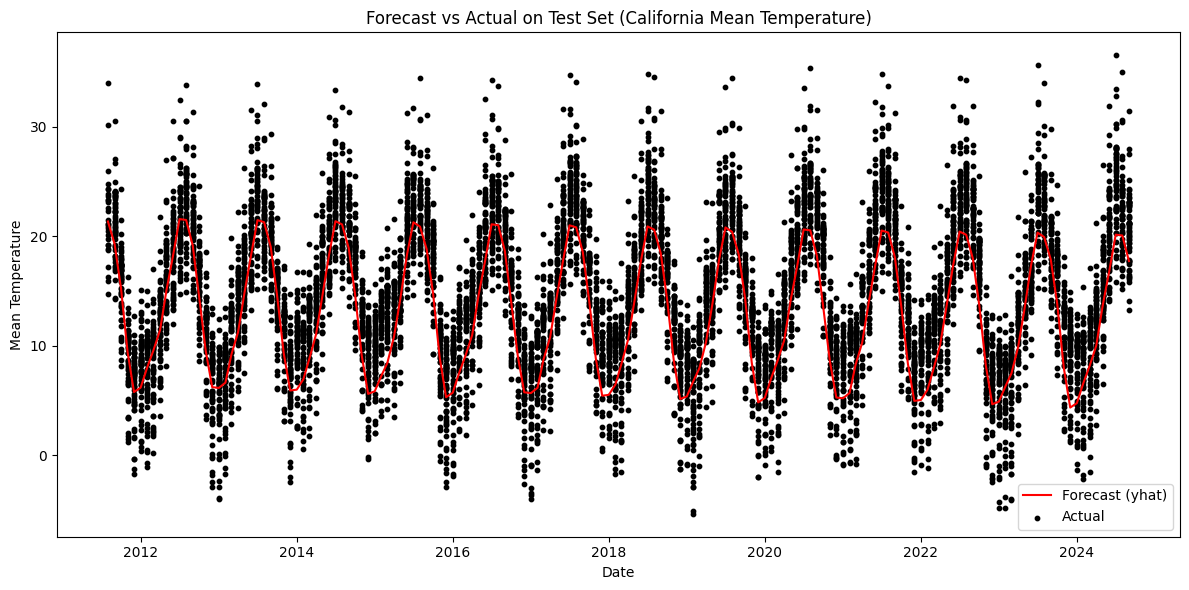

In [12]:
# 将预测结果添加到 test_df 中
test_df = test_df.copy()
test_df['yhat'] = predictions

# 可视化预测结果 vs 实际值
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['yhat'], color='red', label='Forecast (yhat)')
plt.scatter(test_df['ds'], test_df['y'], color='black', s=10, label='Actual')
plt.title("Forecast vs Actual on Test Set (California Mean Temperature)")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.tight_layout()
plt.show()

### Finance (Close_TSLA)

In [13]:
df = pd.read_csv("process_finance_data.csv")
df['ds'] = pd.to_datetime(df['Date'], format="%Y-%m-%d", errors='coerce')
df['y'] = df['Close_TSLA']
df = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)

In [14]:
predictions, train_df, test_df = build_prophet_model(df, train_ratio=0.7)
test_y = test_df['y'].values
rmse, mse, mae, mape, r2, adj_r2 = generate_model_metrics(np.array(predictions), test_y)

print("\n📊 Prophet Model Evaluation: Baltimore Total TEUs (Test Set)")
print(f"Prediction period: {test_df['ds'].min().date()} → {test_df['ds'].max().date()}")
print(f"RMSE:     {rmse:.6f}")
print(f"MSE:      {mse:.6f}")
print(f"MAE:      {mae:.6f}")
print(f"MAPE:     {mape:.2f}%")
print(f"R²:       {r2:.4f}")
print(f"Adj R²:   {adj_r2:.4f}")

02:03:06 - cmdstanpy - INFO - Chain [1] start processing
02:03:06 - cmdstanpy - INFO - Chain [1] done processing
02:03:06 - cmdstanpy - INFO - Chain [1] start processing
02:03:06 - cmdstanpy - INFO - Chain [1] done processing


time usage 0.89s | memory usage 819.77 MB

📊 Prophet Model Evaluation: Baltimore Total TEUs (Test Set)
Prediction period: 2021-04-30 → 2024-03-01
RMSE:     341.538093
MSE:      116648.268677
MAE:      287.822281
MAPE:     135.75%
R²:       -34.4656
Adj R²:   -34.5154


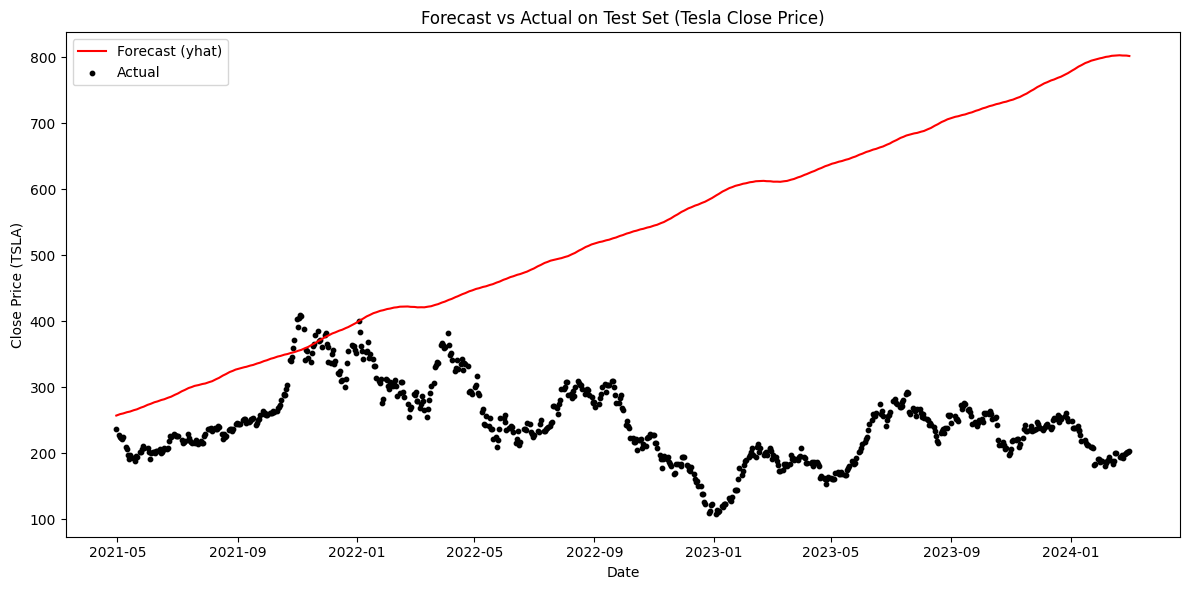

In [15]:
# 加入预测值
test_df = test_df.copy()
test_df['yhat'] = predictions

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['yhat'], color='red', label='Forecast (yhat)')
plt.scatter(test_df['ds'], test_df['y'], color='black', s=10, label='Actual')
plt.title("Forecast vs Actual on Test Set (Tesla Close Price)")
plt.xlabel("Date")
plt.ylabel("Close Price (TSLA)")
plt.legend()
plt.tight_layout()
plt.show()

### Energy (Energy_Price)

In [16]:
df = pd.read_csv("df_no_lag_indicators.csv")

# Parse timestamp
df['ds'] = pd.to_datetime(df['timestamp'], format="%m/%d/%y %H:%M", errors='coerce')

# Set target variable
df['y'] = df['Energy_Price']

# Keep only necessary columns and clean up
df = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)

In [17]:
predictions, train_df, test_df = build_prophet_model(df, train_ratio=0.7, verbose=False)
test_y = test_df['y'].values
rmse, mse, mae, mape, r2, adj_r2 = generate_model_metrics(predictions, test_y)

# === Print results ===
print("\n📊 Prophet Model Evaluation: Energy_Price (Test Set)")
print(f"Prediction period: {test_df['ds'].min().date()} → {test_df['ds'].max().date()}")
print(f"RMSE:     {rmse:.4f}")
print(f"MSE:      {mse:.4f}")
print(f"MAE:      {mae:.4f}")
print(f"MAPE:     {mape:.2f}%")
print(f"R²:       {r2:.4f}")
print(f"Adj R²:   {adj_r2:.4f}")

02:03:46 - cmdstanpy - INFO - Chain [1] start processing
02:04:06 - cmdstanpy - INFO - Chain [1] done processing


time usage 21.46s | memory usage 706.53 MB

📊 Prophet Model Evaluation: Energy_Price (Test Set)
Prediction period: 2024-02-01 → 2025-01-01
RMSE:     1.1066
MSE:      1.2246
MAE:      0.8509
MAPE:     inf%
R²:       -0.8574
Adj R²:   -0.8575


/var/folders/6x/pny936lx1kl5xtl30gj14h3c0000gn/T/ipykernel_5681/3711094413.py:51: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((test - predictions) / test)) * 100 if np.any(test) else 0


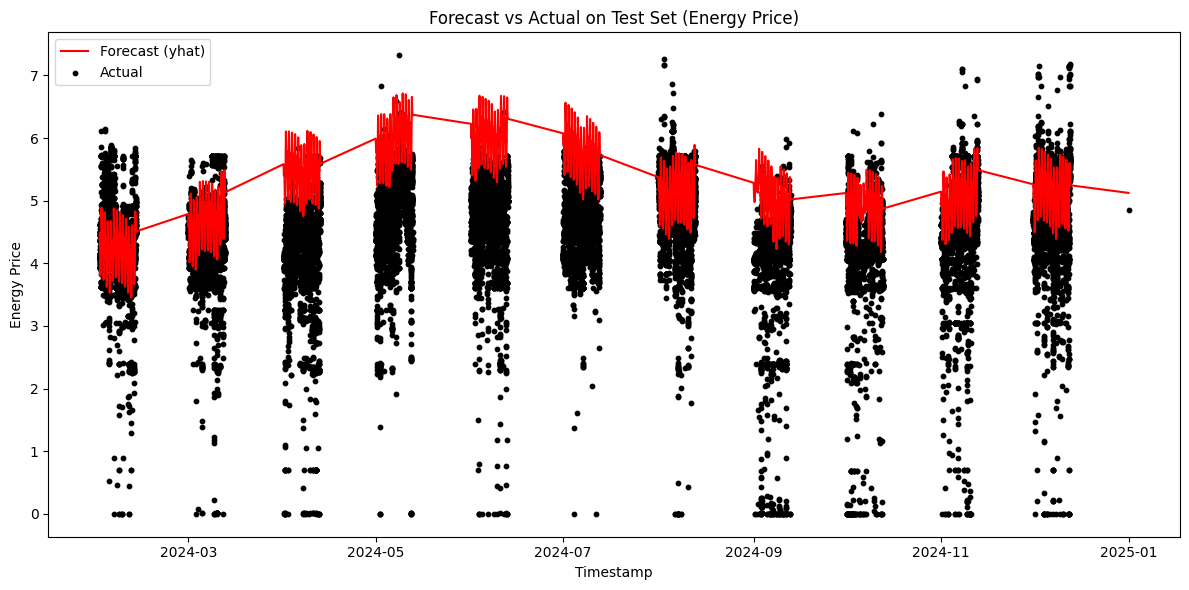

In [19]:

# 添加预测值
test_df = test_df.copy()
test_df['yhat'] = predictions

# 绘图：预测 vs 实际
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['yhat'], color='red', label='Forecast (yhat)')
plt.scatter(test_df['ds'], test_df['y'], color='black', s=10, label='Actual')
plt.title("Forecast vs Actual on Test Set (Energy Price)")
plt.xlabel("Timestamp")
plt.ylabel("Energy Price")
plt.legend()
plt.tight_layout()
plt.show()

### Retail (sales)

In [21]:
# Load the data
df = pd.read_parquet("data_no_lags_s1_i1.parquet") # Choose the file you need

In [22]:
df['ds'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df['y'] = df['sales']
df = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)

# Step 2: Train the Prophet model
predictions, train_df, test_df = build_prophet_model(df, train_ratio=0.7, verbose=False)

# Step 3: Evaluate the model
test_y = test_df['y'].values
rmse, mse, mae, mape, r2, adj_r2 = generate_model_metrics(np.array(predictions), test_y)

# Step 4: Print results
print("\n📊 Prophet Model Evaluation: Cell Sales Forecast")
print(f"Prediction period: {test_df['ds'].min().date()} → {test_df['ds'].max().date()}")
print(f"RMSE:     {rmse:.2f}")
print(f"MSE:      {mse:.2f}")
print(f"MAE:      {mae:.2f}")
print(f"MAPE:     {mape:.2f}%")
print(f"R²:       {r2:.4f}")
print(f"Adj R²:   {adj_r2:.4f}")


02:04:47 - cmdstanpy - INFO - Chain [1] start processing
02:04:47 - cmdstanpy - INFO - Chain [1] done processing
02:04:47 - cmdstanpy - INFO - Chain [1] start processing
02:04:47 - cmdstanpy - INFO - Chain [1] done processing


time usage 0.59s | memory usage 890.88 MB

📊 Prophet Model Evaluation: Cell Sales Forecast
Prediction period: 2016-07-02 → 2017-12-31
RMSE:     4.96
MSE:      24.56
MAE:      4.06
MAPE:     21.95%
R²:       0.4637
Adj R²:   0.4627


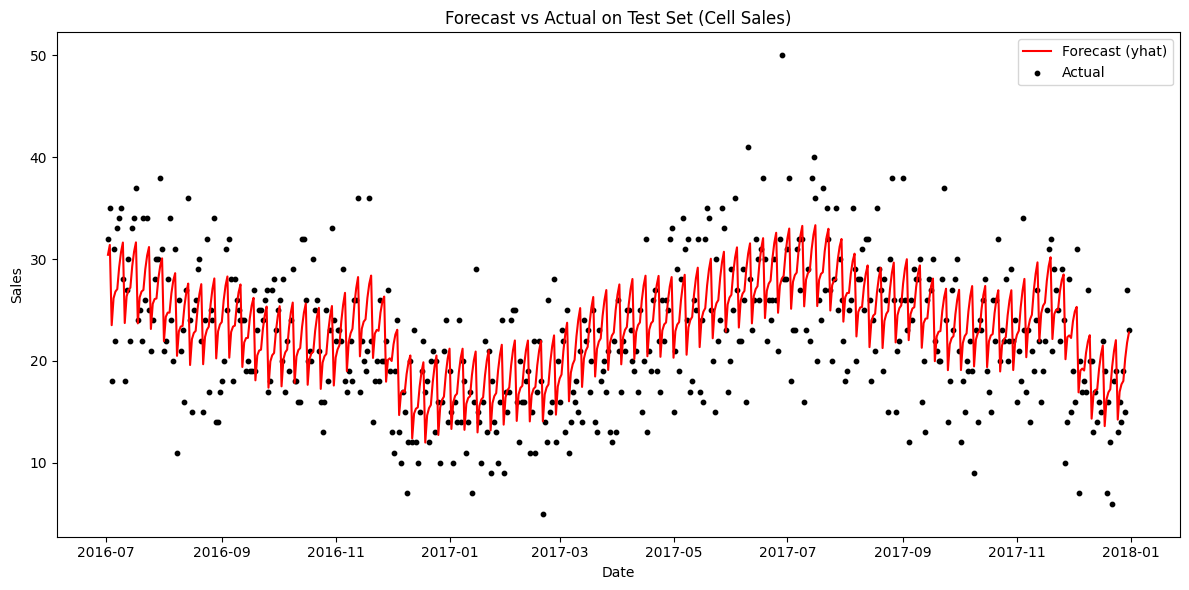

In [24]:
# 加入预测结果
test_df = test_df.copy()
test_df['yhat'] = predictions

# 绘图：实际 vs 预测
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['yhat'], color='red', label='Forecast (yhat)')
plt.scatter(test_df['ds'], test_df['y'], color='black', s=10, label='Actual')
plt.title("Forecast vs Actual on Test Set (Cell Sales)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()